# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [0]:
!wget --header="Host: cs231n.github.io" --header="User-Agent: Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.119 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://cs231n.github.io/assignments2018/assignment1/" --header="Cookie: _ga=GA1.3.210319331.1551607788; _gid=GA1.3.1141866968.1551607788; _gat=1" --header="Connection: keep-alive" "http://cs231n.github.io/assignments/2018/spring1718_assignment1.zip" -O "spring1718_assignment1.zip" -c

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
--2019-07-19 13:18:13--  http://cs231n.github.io/assignments/2018/spring1718_assignment1.zip
Resolving cs231n.github.io (cs231n.github.io)... 185.199.110.153, 185.199.111.153, 185.199.109.153, ...
Connecting to cs231n.github.io (cs231n.github.io)|185.199.110.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73256 (72K) [application/zip]
Saving to: ‘spring1718_assignment1.zip’

spring1718_assignme 100%[===================>]  71.54K  --.-KB/s    in 0.01s   

2019-07-19 13:18:13 (4.88 MB/s) - ‘spring1718_assignment1.zip’ saved [73256/73256]



In [0]:
!unzip -qq spring1718_assignment1.zip

In [0]:
%%bash
cd assignment1
cd cs231n
cd datasets
./get_datasets.sh

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
--2019-07-19 13:18:23--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  419K 6m37s
    50K .......... .......... .......... .......... ..........  0%  835K 4m58s
   100K .......... .......... .......... .......... ..........  0% 22.6M 3m21s
   150K .......... .......... .......... .......... ..........  0% 4.51M 2m40s
   200K .......... .......... .......... .......... ..........  0% 1.01M 2m40s
   250K .......... .......... .......... .......... ..........  0% 22.2M 2m14s
   300K .......... .......... .......... .......... ..........  0% 4.66M 2m0s


In [0]:
# Run some setup code for this notebook.

from __future__ import print_function

import random
import numpy as np
from assignment1.cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [0]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'assignment1/cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [0]:
import numpy as np
from random import shuffle
from past.builtins import xrange

def softmax_loss_naive(W, X, y, reg):
  """
  Softmax loss function, naive implementation (with loops)
  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.
  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength
  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using explicit loops.     #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  num_classes = W.shape[1]
  num_train = X.shape[0]
    
  for i in range(num_train):
    scores = X[i].dot(W) # shape C,
    scores += -np.max(scores) 
    correct_class_score = scores[y[i]] # shape 1,
    loss += -correct_class_score
    sum_class_scores = 0
    dWi = np.zeros_like(W)
    
    for j in range(num_classes):
      # it seems that it is not necessary to exclude the correct class score
      sum_class_scores += np.exp(scores[j])
      if y[i] == j:
        dWi[:, j] += X[i] * (np.exp(scores[j]) / np.sum(np.exp(scores)) - 1)
      else:
        dWi[:, j] += X[i] * np.exp(scores[j]) / np.sum(np.exp(scores))
    
    dW += dWi
    loss += np.log(sum_class_scores)

  loss += reg * np.sum(W * W)
  loss /= num_train
  dW += 2 * reg * W
  dW /= num_train
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW


def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.
  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  num_classes = W.shape[1]
  num_train = X.shape[0]
    
  scores = X.dot(W)
  scores += -np.max(scores).reshape(-1, 1)
  true_class_scores = np.choose(y, scores.T)
  true_class_idx = np.vstack([np.arange(y.shape[0]), y]).T

  loss = np.sum(-scores[true_class_idx[:, 0], true_class_idx[:, 1]] + np.log(np.sum(np.exp(scores), axis=1)))
  loss += reg * np.sum(W * W)
  loss /= num_train
 
  dW_parentheses = np.exp(scores) / np.sum(np.exp(scores), axis=1).reshape(-1, 1)
  dW_parentheses[true_class_idx[:, 0], true_class_idx[:, 1]] -= 1
  dW = X.T.dot(dW_parentheses)
  dW += 2 * reg * W
  dW /= num_train
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW


In [0]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

#from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.359515
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [0]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from assignment1.cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.588395 analytic: 0.588394, relative error: 9.633239e-08
numerical: -0.198073 analytic: -0.198073, relative error: 6.345307e-08
numerical: 0.460255 analytic: 0.460255, relative error: 5.567057e-08
numerical: 2.577943 analytic: 2.577943, relative error: 1.777821e-08
numerical: -0.586402 analytic: -0.586403, relative error: 6.499942e-08
numerical: 0.880220 analytic: 0.880220, relative error: 2.989723e-09
numerical: -2.839178 analytic: -2.839178, relative error: 9.438984e-09
numerical: -0.476492 analytic: -0.476492, relative error: 3.628834e-08
numerical: -3.161603 analytic: -3.161603, relative error: 2.448049e-08
numerical: -0.405659 analytic: -0.405659, relative error: 1.801158e-08
numerical: 3.838277 analytic: 3.838277, relative error: 2.942180e-08
numerical: 1.064757 analytic: 1.064757, relative error: 3.984951e-08
numerical: -1.356232 analytic: -1.356232, relative error: 3.024764e-08
numerical: -0.678240 analytic: -0.678240, relative error: 4.045585e-08
numerical: -1.0347

In [0]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

#from assignment1.cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.359515e+00 computed in 0.255664s
vectorized loss: 2.359515e+00 computed in 0.006825s
Loss difference: 0.000000
Gradient difference: 0.000000


In [0]:
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, x, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.
        :param x: A numpy array of shape (N, D) containing training data; there are N
                  training samples each of dimension D.
        :param y: A numpy array of shape (N,) containing training labels; y[i] = c
                  means that X[i] has label 0 <= c < C for C classes.
        :param learning_rate: (float) learning rate for optimization.
        :param reg: (float) regularization strength.
        :param num_iters: (integer) number of steps to take when optimizing
        :param batch_size: (integer) number of training examples to use at each step.
        :param verbose: (boolean) If true, print progress during optimization.
        :return loss_history: A list containing the value of the loss function at each training iteration.
        """

        num_train, dim = x.shape
        num_classes = np.max(y) + 1  # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []

        for it in range(num_iters):
            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            idx = np.random.choice(range(x.shape[0]), size=batch_size)
            x_batch, y_batch = x[idx, :], y[idx]
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            # evaluate loss and gradient
            loss, grad = self.loss(x_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO: Update the weights using the gradient and the learning rate.    #
            #########################################################################
            self.W -= learning_rate * grad
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, x):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.
        :param x: A numpy array of shape (N, D) containing training data; there are N
                  training samples each of dimension D.
        :return y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
                        array of length N, and each element is an integer giving the
                        predicted class.
        """
        ###########################################################################
        # TODO: Implement this method. Store the predicted labels in y_pred.      #
        ###########################################################################
        y_pred = np.argmax(x.dot(self.W), axis=1)
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred

    def loss(self, x_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.
        :param x_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        :param y_batch: A numpy array of shape (N,) containing labels for the mini-batch.
        :param reg: (float) regularization strength.
        :return: A tuple containing:
                     - loss as a single float
                     - gradient with respect to self.W; an array of the same shape as W
        """
        pass


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, x_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, x_batch, y_batch, reg)


class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, x_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, x_batch, y_batch, reg)

In [0]:
%%time

from tqdm import tqdm_notebook

# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
#from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax_clf = None
learning_rates = np.linspace(3e-7, 5e-7, 3)
regularization_strengths = np.linspace(5e3, 5e4, 3)

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in tqdm_notebook(learning_rates):
    for reg in tqdm_notebook(regularization_strengths):
        softmax_clf = Softmax()
        _ = softmax_clf.train(X_train, y_train, learning_rate=lr, 
                      reg=reg,
                      num_iters=1500, verbose=False)
        y_train_pred = softmax_clf.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = softmax_clf.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_acc, val_acc))
        if val_acc > best_val:
            best_val = val_acc
            best_softmax_clf = softmax_clf
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 3.000000e-07 reg 5.000000e+03 train accuracy: 0.297837 val accuracy: 0.296000
lr 3.000000e-07 reg 2.750000e+04 train accuracy: 0.303755 val accuracy: 0.332000
lr 3.000000e-07 reg 5.000000e+04 train accuracy: 0.308184 val accuracy: 0.308000


lr 4.000000e-07 reg 5.000000e+03 train accuracy: 0.306143 val accuracy: 0.331000
lr 4.000000e-07 reg 2.750000e+04 train accuracy: 0.320184 val accuracy: 0.311000
lr 4.000000e-07 reg 5.000000e+04 train accuracy: 0.327837 val accuracy: 0.332000


lr 5.000000e-07 reg 5.000000e+03 train accuracy: 0.325612 val accuracy: 0.312000
lr 5.000000e-07 reg 2.750000e+04 train accuracy: 0.332612 val accuracy: 0.339000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.343980 val accuracy: 0.348000

best validation accuracy achieved during cross-validation: 0.348000
CPU times: user 5min 9s, sys: 8min 29s, total: 13min 38s
Wall time: 3min 26s


In [0]:

# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax_clf.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

Softmax on raw pixels final test set accuracy: 0.340000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

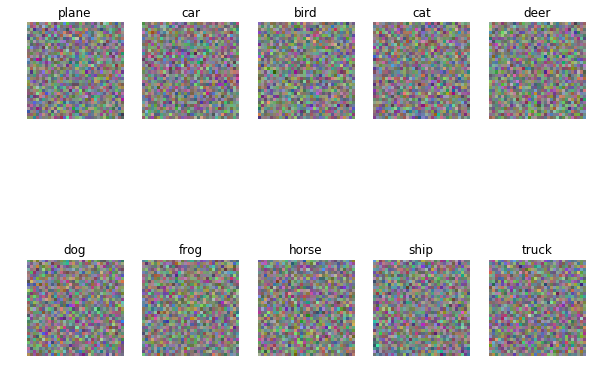

In [0]:

# Visualize the learned weights for each class
w = best_softmax_clf.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])